In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)

# Inspect the columns name of each tamble
measurement_col = inspector.get_columns('measurement')
station_col = inspector.get_columns('station')

print(f"measurement columns")
for c in measurement_col:
    print(c['name'], c["type"])
print(f"----------------------")
print(f"station columns")
for c in station_col:
    print(c['name'], c["type"])    

measurement columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------
station columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


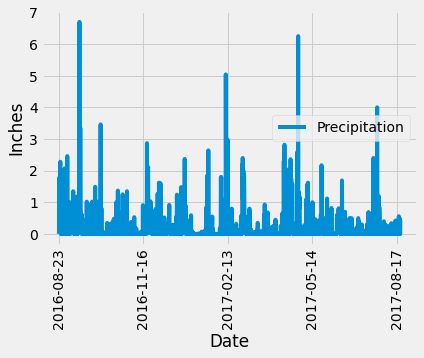

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date_string = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(latest_date_string[0])
latest_date=dt.datetime.strptime(latest_date_string[0],'%Y-%m-%d')
#print(latest_date)

# Calculate the date 1 year ago from the last data point in the database
query_date=dt.date(latest_date.year -1, latest_date.month, latest_date.day)
#print(query_date)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Prcp_12months_df = pd.DataFrame(results, columns=['Date','Precipitation'])
Prcp_12months_df.set_index('Date', inplace=True)
Prcp_12months_df.dropna(how='any', inplace=True)
# Sort the dataframe by date
Prcp_12months_df.sort_values('Date', ascending=True, inplace=True)
#Prcp_12months_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
ax = Prcp_12months_df.plot(rot=90);
ax.set_ylabel("Inches");

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Prcp_12months_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
print(f"Ther are {station_count} stations availabe in this dataset")

Ther are 9 stations availabe in this dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_act=session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_act

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query_station=station_act[0][0]
#print(query_station)
temp_describe=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
results = session.query(Measurement.station,*temp_describe).\
            filter(Measurement.station == query_station).all()
print(results)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


Text(0, 0.5, 'Frequency')

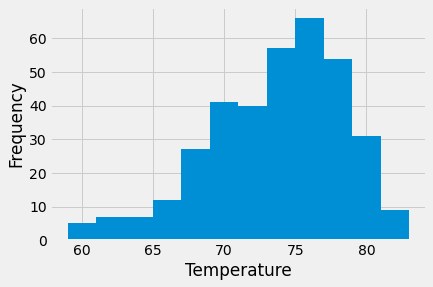

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date_str_stat = session.query(Measurement.date).\
                        filter(Measurement.station == query_station).\
                        order_by(Measurement.date.desc()).first()
#print(latest_date_str_stat[0])
latest_date_stat=dt.datetime.strptime(latest_date_str_stat[0],'%Y-%m-%d')
#print(latest_date_stat)

query_date_stat=dt.date(latest_date_stat.year -1, latest_date_stat.month, latest_date_stat.day)
#print(query_date_stat)

results = session.query(Measurement.tobs).filter(Measurement.date>query_date_stat).\
            filter(Measurement.station == query_station).all()
temp_results = list(np.ravel(results))
plt.hist(temp_results, bins=12,label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

## Bonus Challenge Assignment

## Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's read_csv() to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [17]:
# Query the average temperature in June at all stations
avg_june_temp = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date)== "06").\
                group_by(Measurement.station).all()
avg_june_temp

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [18]:
# Query the average temperature in December at all stations
avg_dec_temp = session.query(func.avg(Measurement.tobs)).\
                filter(func.strftime("%m", Measurement.date)== "12").\
                group_by(Measurement.station).all()
avg_dec_temp

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [19]:
# Query all the data of temperature in June/Decemeber at all stations
all_temp_june_query=session.query(Measurement.tobs).\
            filter(func.strftime("%m",Measurement.date) == '06').all()
all_temp_dec_query=session.query(Measurement.tobs).\
            filter(func.strftime("%m",Measurement.date) == '12').all()

temp_june_data=list(np.ravel(all_temp_june_query))
temp_dec_data=list(np.ravel(all_temp_dec_query))

# Use T test to determine the difference of average temperatures
# H0 hypothesis: There is no significant difference between the average temperatures of June and December.
# H1 hypothesis: There is significant difference between the average temperatrues of June and December.

stats.ttest_ind(temp_june_data, temp_dec_data, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

P-value is smaller than 0.05. So it is reasonable to reject the null hypothesis.
This means that there is a significant difference between the average temperatrues of June and December.

## Temperature Analysis II

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-12-15'
end_date = '2016-12-27'
temp_pre =calc_temps(start_date, end_date)
tmin,tavg,tmax=temp_pre[0]
#tavg=temp_pre[1]
#tmax=temp_pre[2]
print(tmin,tavg,tmax)

60.0 71.75903614457832 78.0


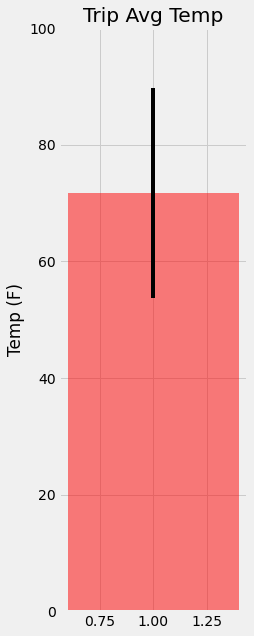

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,10));
plt.bar(1,tavg,yerr=tmax-tmin,color='red',alpha=.5);
plt.ylim(0,100);
plt.ylabel("Temp (F)");
plt.title("Trip Avg Temp");

## Daily Rainfall Average

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-12-15'
end_date = '2016-12-27'
rainfall_sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
results=session.query(*rainfall_sel).filter(Measurement.station==Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
for precp in results:
    print(precp)

(13, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(13, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(13, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(13, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(11, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(11, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(1, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-12-15'
end_date = '2017-12-27'

# Use the start and end date to create a range of dates
start_dt = dt.datetime.strptime(start_date,'%Y-%m-%d')
end_dt = dt.datetime.strptime(end_date,'%Y-%m-%d')

tmp_dt=start_dt
dt_list=[]

while tmp_dt <= end_dt:
    dt_list.append(tmp_dt)
    tmp_dt=tmp_dt+dt.timedelta(days=1)

# Stip off the year and save a list of %m-%d strings
md_list=[dt.datetime.strftime(x,'%m-%d') for x in dt_list]
print(md_list)

# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list=[daily_normals(day)[0] for day in md_list]
print(normal_list)

['12-15', '12-16', '12-17', '12-18', '12-19', '12-20', '12-21', '12-22', '12-23', '12-24', '12-25', '12-26', '12-27']
[(62.0, 71.34, 79.0), (60.0, 69.62264150943396, 82.0), (63.0, 70.64, 77.0), (63.0, 71.28, 77.0), (67.0, 72.0, 78.0), (65.0, 72.91304347826087, 81.0), (67.0, 72.13953488372093, 78.0), (67.0, 71.1304347826087, 77.0), (61.0, 70.34693877551021, 78.0), (62.0, 70.0625, 78.0), (60.0, 71.75, 79.0), (63.0, 71.44680851063829, 77.0), (62.0, 71.91666666666667, 79.0)]


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df=pd.DataFrame(normal_list,index=md_list,columns=['tmin','tavg','tmax'])
normal_df

,tmin,tavg,tmax
12-15,62.0,71.340000,79.0
12-16,60.0,69.622642,82.0
12-17,63.0,70.640000,77.0
12-18,63.0,71.280000,77.0
12-19,67.0,72.000000,78.0
12-20,65.0,72.913043,81.0
12-21,67.0,72.139535,78.0
12-22,67.0,71.130435,77.0
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0


Text(0, 0.5, 'Temperature')

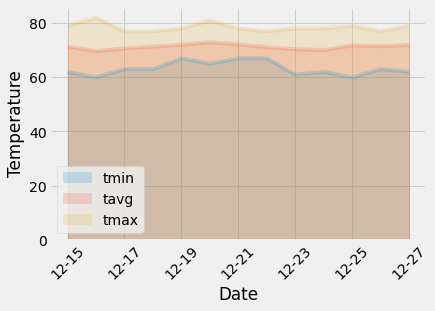

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area",stacked=False,rot=45,alpha=0.2);
plt.xlabel('Date');
plt.ylabel('Temperature')